## 分析91APP資料，希望找到收貨狀態與其餘欄位之間的關聯性。

In [1]:
library(ggplot2)
library(cluster)
library(factoextra)
library(arules)

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


In [2]:
#proder <- read.csv("/Users/kiki/Dropbox/台大/碩二/資料科學/Data/PromotionOrders.csv")
order <- read.csv("/Users/kiki/Dropbox/台大/碩二/資料科學/Data/Orders.csv")
member <- read.csv("/Users/kiki/Dropbox/台大/碩二/資料科學/Data/Member.csv")
#coupon <- read.csv("/Users/kiki/Dropbox/台大/碩二/資料科學/Data/ECoupon.csv")

In [3]:
#轉換資料格式
#member$MemberId <- as.factor(member$MemberId)
order$MemberId <- as.factor(order$MemberId)
order$ECouponId <- as.factor(order$ECouponId)
order$StatusDef <- as.factor(order$StatusDef)
order$DeliverTypeDef <- as.factor(order$DeliverTypeDef)
order$SalesOrderSlaveId <- as.factor(order$SalesOrderSlaveId)
order$SalesOrderReceiverId <- as.factor(order$SalesOrderReceiverId)
order$SalePageId <- as.factor(order$SalePageId)
order$UnitPrice <- as.numeric(order$UnitPrice)
order$PromotionDiscount <- as.numeric(order$PromotionDiscount)
#proder$SalesOrderSlaveId <- as.factor(proder$SalesOrderSlaveId)
#coupon$ECouponId <- as.factor(coupon$ECouponId)
order[[1]] <- as.character(order[[1]])

In [4]:
#切割年月日
order$Year <- substring(order$DateId,1,4)
order$Month <- substring(order$DateId,5,6)
order$Day <- substring(order$DateId,7,8)

In [5]:
order$nDate <- paste(order$Year,order$Month,order$Day,sep = "/")

In [6]:
#轉換成星期
order$weekdate <- weekdays(as.Date(order$nDate))
order$weekdate <- as.factor(order$weekdate)

In [7]:
#取出需要的縣市的位置
ind <- which(order$City == "高雄市" | order$City == "花蓮縣" | order$City == "基隆市" | order$City == "嘉義市" | order$City == "嘉義縣" | order$City == "苗栗縣" | order$City == "南投縣" | order$City == "澎湖縣" | order$City == "屏東市" | order$City == "屏東縣" | order$City == "台北市" | order$City == "台東市" | order$City == "台東縣" | order$City == "台南市" | order$City == "台中市" | order$City == "桃園市" | order$City == "桃園縣" | order$City == "新北市" | order$City == "新竹市" | order$City == "新竹縣" | order$City == "宜蘭縣" | order$City == "雲林縣" | order$City == "彰化縣")

In [8]:
order <- order[ind,]

In [9]:
head(order)

DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,SalesOrderSlaveId,SalePageId,IsMajor,IsGift,⋯,StoreId,DeliverTypeDef,StatusDef,ReturnGoodsDateId,CauseDef,Year,Month,Day,nDate,weekdate
20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO\xef\x05\x197',Web,Mobile,SevenEleven,4457777,1242871,True,False,⋯,910828,SevenEleven,Finish,NA,,2015,07,03,2015/07/03,Friday
20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO\xef\x05\x197',Web,Mobile,SevenEleven,4457778,1242880,True,False,⋯,910828,SevenEleven,Finish,NA,,2015,07,03,2015/07/03,Friday
20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO\xef\x05\x197',Web,Mobile,SevenEleven,4457779,1242880,True,False,⋯,910828,SevenEleven,Finish,NA,,2015,07,03,2015/07/03,Friday
20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO\xef\x05\x197',Web,Mobile,SevenEleven,4457780,1175574,True,False,⋯,910828,SevenEleven,Finish,NA,,2015,07,03,2015/07/03,Friday
20150703,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\xd9\x14""",Web,Mobile,SevenEleven,4457791,1194488,True,False,⋯,114071,SevenEleven,Finish,NA,,2015,07,03,2015/07/03,Friday
20150703,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\xd9\x14""",Web,Mobile,SevenEleven,4457792,1256479,True,False,⋯,114071,SevenEleven,Finish,NA,,2015,07,03,2015/07/03,Friday


In [10]:
#取出需要的位置
ind <- which(order$StatusDef == "Finish" | order$StatusDef == "ReturnGoods" | order$StatusDef == "Overdue" | order$StatusDef == "Cancel")

In [11]:
order_status <- order[ind,]

In [12]:
names(order_status)

[1] "DateId"                      "MemberId"                   
 [3] "OrderGroupCode"              "TrackSourceTypeDef"         
 [5] "TrackDeviceTypeDef"          "PayProfileTypeDef"          
 [7] "SalesOrderSlaveId"           "SalePageId"                 
 [9] "IsMajor"                     "IsGift"                     
[11] "IsSalePageGift"              "Quantity"                   
[13] "UnitPrice"                   "PromotionDiscount"          
[15] "ECouponId"                   "ECouponDiscount"            
[17] "SalesOrderSlaveTotalPayment" "SalesOrderSlaveDateTime"    
[19] "SalesOrderReceiverId"        "City"                       
[21] "District"                    "ZipCode"                    
[23] "StoreName"                   "StoreId"                    
[25] "DeliverTypeDef"              "StatusDef"                  
[27] "ReturnGoodsDateId"           "CauseDef"                   
[29] "Year"                        "Month"                      
[31] "Day"                         "nDate"                      
[33] "weekdate"

In [13]:
order_status$NT <- 0
order_status$TC <- 0
order_status$TP <- 0
order_status$TN <- 0
order_status$TT <- 0
order_status$JY <- 0
order_status$KL <- 0
order_status$IL <- 0
order_status$PT <- 0
order_status$CH <- 0
order_status$XP <- 0
order_status$XC <- 0
order_status$TY <- 0
order_status$PH <- 0
order_status$HL <- 0
order_status$ML <- 0
order_status$YL <- 0
order_status$GH <- 0

In [14]:
ind <- which(order_status$City == "高雄市")
order_status$GH[ind] <- 1
ind <- which(order_status$City == "雲林縣")
order_status$YL[ind] <- 1
ind <- which(order_status$City == "苗栗縣")
order_status$ML[ind] <- 1
ind <- which(order_status$City == "花蓮縣")
order_status$HL[ind] <- 1
ind <- which(order_status$City == "澎湖縣")
order_status$PH[ind] <- 1
ind <- which(order_status$City == "桃園縣" | order_status$City == "桃園市")
order_status$TY[ind] <- 1
ind <- which(order_status$City == "新竹縣" | order_status$City == "新竹市")
order_status$XC[ind] <- 1
ind <- which(order_status$City == "新北市")
order_status$XP[ind] <- 1
ind <- which(order_status$City == "彰化縣")
order_status$CH[ind] <- 1
ind <- which(order_status$City == "屏東縣" | order_status$City == "屏東市")
order_status$PT[ind] <- 1
ind <- which(order_status$City == "宜蘭縣")
order_status$IL[ind] <- 1
ind <- which(order_status$City == "基隆市")
order_status$KL[ind] <- 1
ind <- which(order_status$City == "嘉義縣" | order_status$City == "嘉義市")
order_status$JY[ind] <- 1
ind <- which(order_status$City == "台東縣" | order_status$City == "台東市")
order_status$TT[ind] <- 1
ind <- which(order_status$City == "台南市")
order_status$TN[ind] <- 1
ind <- which(order_status$City == "台北市")
order_status$TP[ind] <- 1
ind <- which(order_status$City == "台中市")
order_status$TC[ind] <- 1
ind <- which(order_status$City == "南投縣")
order_status$NT[ind] <- 1

In [15]:
order_status$Mon <- 0
order_status$Tue <- 0
order_status$Wed <- 0
order_status$Thur <- 0
order_status$Fri <- 0
order_status$Sat <- 0
order_status$Sun <- 0

In [16]:
ind <- which(order_status$weekdate == "Monday")
order_status$Mon[ind] <- 1
ind <- which(order_status$weekdate == "Tuesday")
order_status$Tue[ind] <- 1
ind <- which(order_status$weekdate == "Wednesday")
order_status$Wed[ind] <- 1
ind <- which(order_status$weekdate == "Thursday")
order_status$Thur[ind] <- 1
ind <- which(order_status$weekdate == "Friday")
order_status$Fri[ind] <- 1
ind <- which(order_status$weekdate == "Saturday")
order_status$Sat[ind] <- 1
ind <- which(order_status$weekdate == "Sunday")
order_status$Sun[ind] <- 1

# PCA(Principal Component Analysis)

In [17]:
order_sub <- order[,c(12,13,16,26)]

### 選擇「單位價格」「數量」「折價券折抵金額」三項數值來做PCA

In [18]:
pca <- prcomp(formula = ~ UnitPrice+Quantity+ECouponDiscount, 
              data = order_status,
              scale = TRUE)

In [19]:
pca

Standard deviations (1, .., p=3):
[1] 1.0836755 1.0056373 0.9024084

Rotation (n x k) = (3 x 3):
                       PC1        PC2       PC3
UnitPrice       -0.7080659 -0.1619281 0.6873296
Quantity         0.0107622  0.9707652 0.2397896
ECouponDiscount  0.7060643 -0.1771840 0.6856230

### 根據凱莎原則，選取特徵值大於1的主成份，因此選擇前兩個主成份是比較好的選擇。

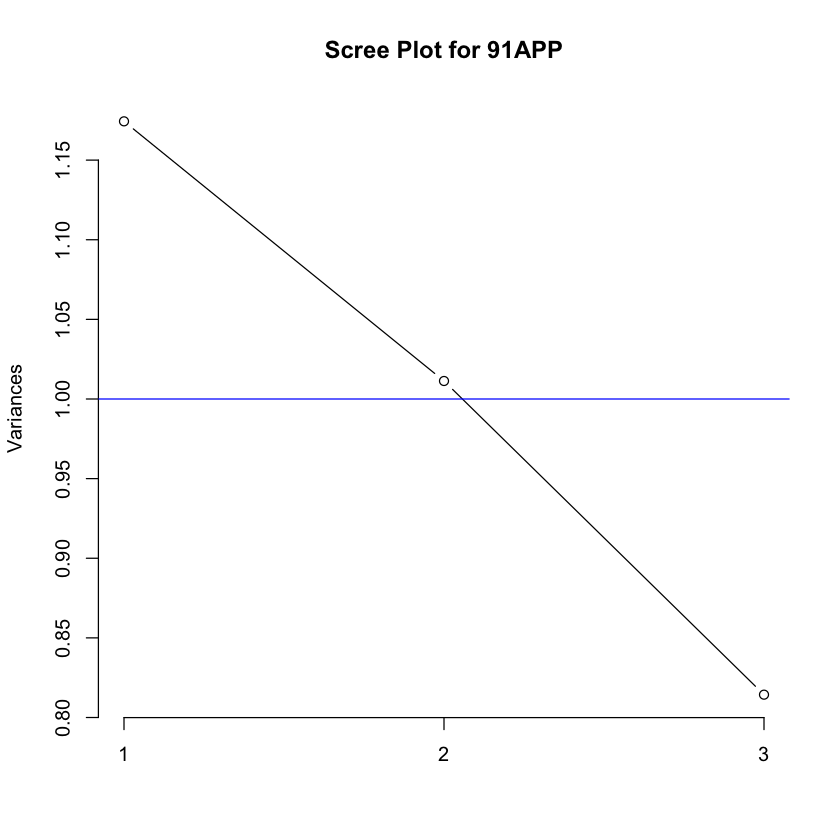

In [20]:
plot(pca,         # 放pca
     type="line", # 用直線連結每個點
     main="Scree Plot for 91APP") # 主標題
abline(h=1, col="blue")

In [21]:
top2_pca <- pca$x[, 1:2]
top2.pca.eigenvector <- pca$rotation[, 1:2]
first.pca <- top2.pca.eigenvector[, 1]
second.pca <- top2.pca.eigenvector[, 2]

In [22]:
top2.pca.eigenvector

,PC1,PC2
UnitPrice,-0.7080659,-0.1619281
Quantity,0.0107622,0.9707652
ECouponDiscount,0.7060643,-0.1771840


### Ecoupon Discount及Unit Price與PC1呈現相關性，看起來PC1和「支付金額」有關。
#### ps. 特徵向量是獨特的值，只要是在同一方向上，不管是正向還是負向純量縮放，都是相同的。

UnitPrice        Quantity ECouponDiscount 
     -0.7080659       0.0107622       0.7060643

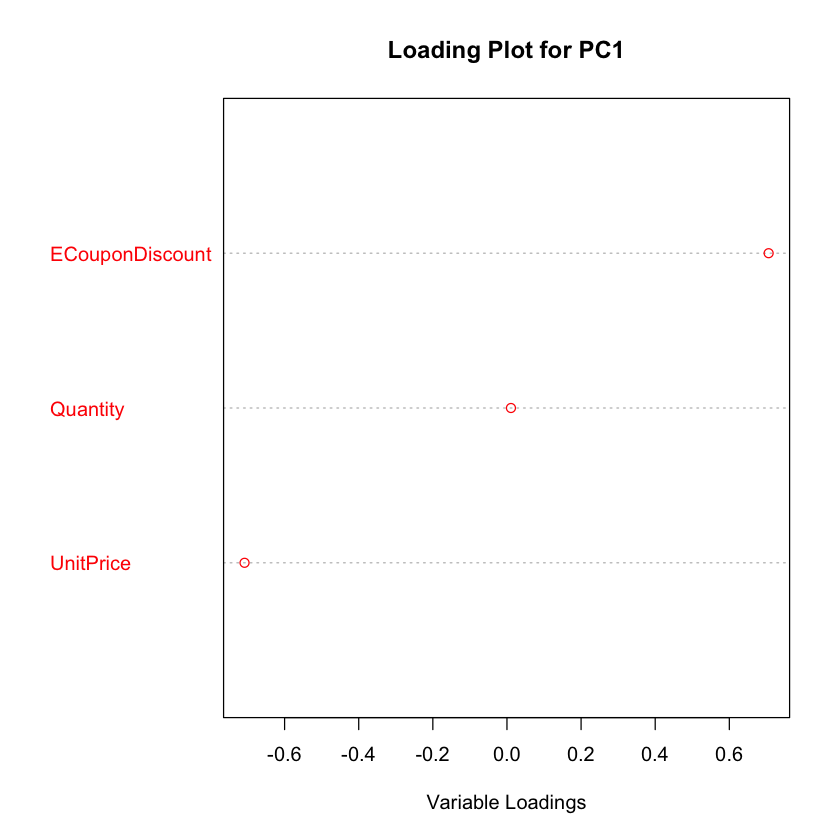

In [23]:
first.pca[order(first.pca, decreasing=FALSE)]  
dotchart(first.pca[order(first.pca, decreasing=FALSE)] ,   # 排序後的係數
         main="Loading Plot for PC1",                      # 主標題
         xlab="Variable Loadings",                         # x軸的標題
         col="red")                                        # 顏色

### Quantity與PC2呈現正相關，看起來和「購買數量」有關。

ECouponDiscount       UnitPrice        Quantity 
     -0.1771840      -0.1619281       0.9707652

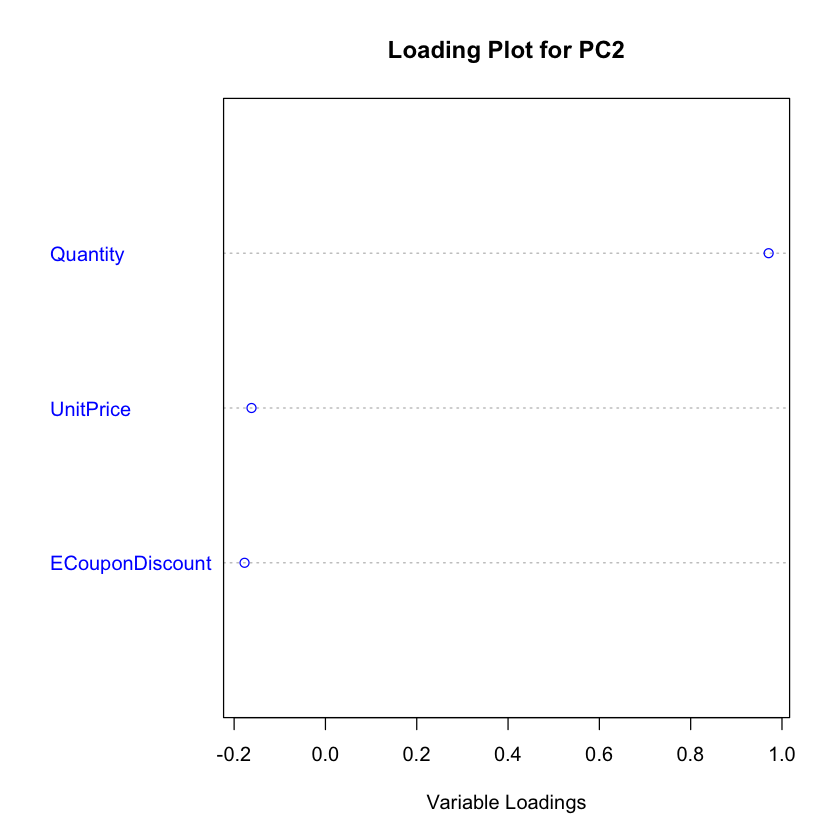

In [24]:
second.pca[order(second.pca, decreasing=FALSE)]  
dotchart(second.pca[order(second.pca, decreasing=FALSE)] ,  # 排序後的係數
         main="Loading Plot for PC2",                       # 主標題
         xlab="Variable Loadings",                          # x軸的標題
         col="blue")                                        # 顏色

In [25]:
scaled_df <- apply(order_sub[,1:3], 2, scale)

In [26]:
PC1 <- as.matrix(scaled_df) %*% top2.pca.eigenvector[,1]
PC2 <- as.matrix(scaled_df) %*% top2.pca.eigenvector[,2]


In [27]:
PC <- data.frame(Status = order_sub$StatusDef, PC1, PC2)
head(PC)

Status,PC1,PC2
Finish,0.4219928,0.6105815
Finish,0.4089648,-0.5645607
Finish,0.4089648,-0.5645607
Finish,0.4112081,-0.3622183
Finish,0.4004233,-1.3350182
Finish,0.4080158,-0.6501671


### 越接近中間，表示處於平均值，從圖中發現，優惠金額較低時，訂單完成的比例下降。
### 可以推測出優惠越高，民眾越容易完成訂單，按時取貨。

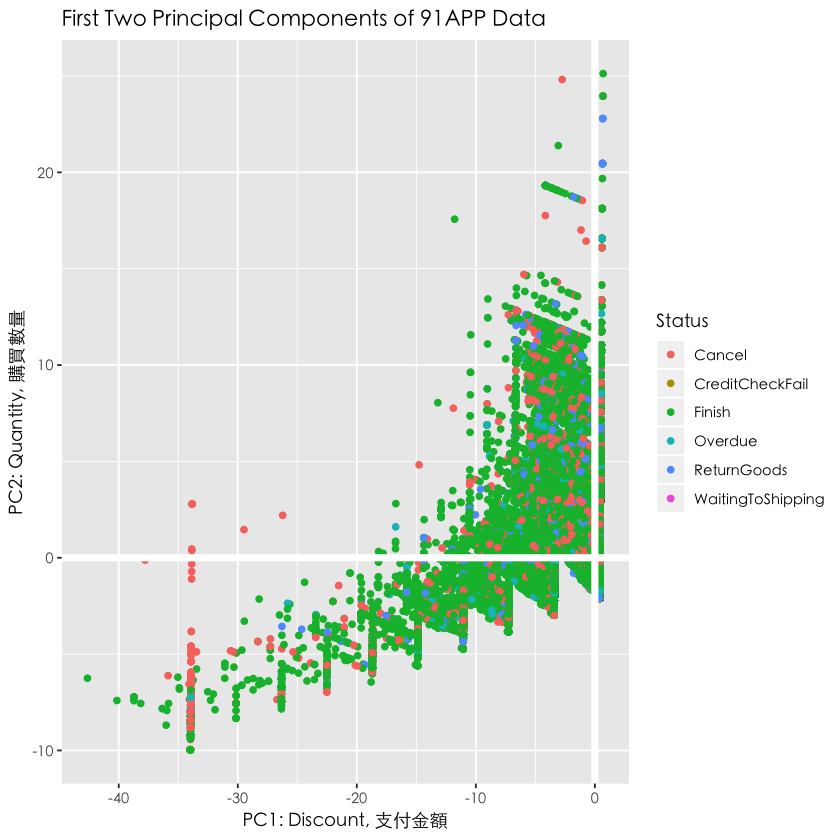

In [28]:
options(warn=-1)
par(family="STHeitiTC-Light")
ggplot(PC, aes(x=PC1, y=PC2, color=Status)) + 
  geom_point() +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  #geom_text(aes(label = Status), size = 3) +
  xlab("PC1: Discount, 支付金額") + 
  ylab("PC2: Quantity, 購買數量") + 
  ggtitle("First Two Principal Components of 91APP Data")+
  theme(text=element_text(family="STHeitiTC-Light"))
options(warn=1) 

# K-means Cluster

### 選取「星期」「縣市」「數量」「單位價格」「折扣優惠」進行分析

In [26]:
order_sub <- order_status[,c(12,13,16,34:58)]

### 因為k means 有數量限制(not more than 65536 are allowed)，因此抽樣1000筆資料進行分析

In [28]:
set.seed(10)
s <- sample(nrow(order_sub), 1000)
order_sample <- order_sub[s, ]
kmeans.cluster <- kmeans(order_sample, centers=4) 
kmedoid.cluster <- pam(order_sample, k=4) 

### 從下表及下圖珠我們發現，這幾項因素無法將資料分成符合運送狀態的四群(包含Finish, Cancel, Overdue, ReturnGoods)，因此他們不是合適的分群因子

In [23]:
table(kmedoid.cluster$clustering, order_status[s, ]$StatusDef) 

   
    Cancel CreditCheckFail Finish Overdue ReturnGoods WaitingToShipping
  1     59               0    325      30          18                 0
  2     33               0    176      15          14                 0
  3     34               0    196      14          13                 0
  4     10               0     57       3           3                 0

Warning message:
“argument frame is deprecated; please use ellipse instead.”Warning message:
“argument frame.type is deprecated; please use ellipse.type instead.”

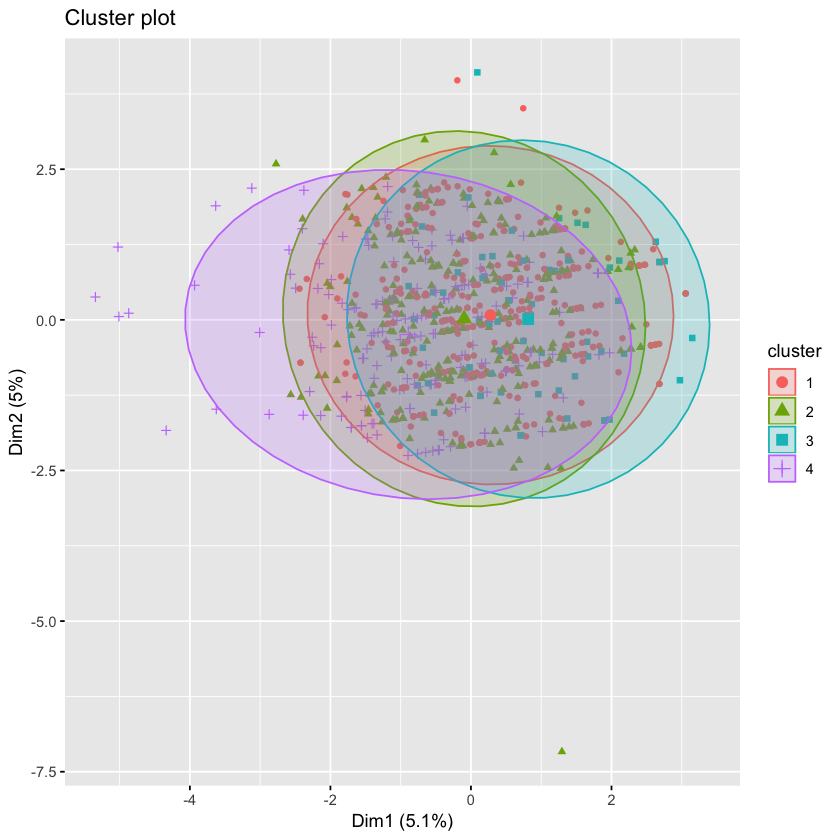

In [30]:
fviz_cluster(kmeans.cluster,
             data = order_sample,
             geom = c("point"), # 點和標籤 c("point","text")
             frame.type = "norm") 

# Apriori

In [67]:
order_status$NT<-as.factor(order_status$NT)
order_status$TC<-as.factor(order_status$TC)
order_status$TP<-as.factor(order_status$TP)
order_status$TN<-as.factor(order_status$TN)
order_status$TT<-as.factor(order_status$TT)
order_status$JY<-as.factor(order_status$JY)
order_status$KL<-as.factor(order_status$KL)
order_status$IL<-as.factor(order_status$IL)
order_status$PT<-as.factor(order_status$PT)
order_status$CH<-as.factor(order_status$CH)
order_status$XP<-as.factor(order_status$XP)
order_status$XC<-as.factor(order_status$XC)
order_status$TY<-as.factor(order_status$TY)
order_status$PH<-as.factor(order_status$PH)
order_status$HL<-as.factor(order_status$HL)
order_status$ML<-as.factor(order_status$ML)
order_status$YL<-as.factor(order_status$YL)
order_status$GH<-as.factor(order_status$GH)
order_status$Mon<-as.factor(order_status$Mon)
order_status$Tue<-as.factor(order_status$Tue)
order_status$Wed<-as.factor(order_status$Wed)
order_status$Thur<-as.factor(order_status$Thur)
order_status$Fri<-as.factor(order_status$Fri)
order_status$Sat<-as.factor(order_status$Sat)
order_status$Sun<-as.factor(order_status$Sun)

In [40]:
order_sub <- order_status[,c(6,20,33,26)]

In [41]:
str(order_sub)

'data.frame':	5492607 obs. of  4 variables:
 $ PayProfileTypeDef: Factor w/ 5 levels "ATM","CreditCardOnce",..: 5 5 5 5 5 5 5 5 3 3 ...
 $ City             : Factor w/ 45 levels "","<fo","1st",..: 30 30 30 30 39 39 39 39 26 26 ...
 $ weekdate         : Factor w/ 7 levels "Friday","Monday",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ StatusDef        : Factor w/ 6 levels "Cancel","CreditCheckFail",..: 3 3 3 3 3 3 3 3 3 3 ...


### 選擇「星期」「縣市」「付款方式」等factor值來做Apriori

In [44]:
rule <- apriori(order_sub, 
                parameter=list(minlen=3, supp=0.05, conf=0.7),  
                appearance = list(default="lhs",
                                  rhs=c("StatusDef=Finish", "StatusDef=ReturnGoods", "StatusDef=Overdue", "StatusDef=Cancel") 
                                  # 右手邊顯示的特徵
                                  )
                )  


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.7    0.1    1 none FALSE            TRUE       5    0.05      3
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 274630 

set item appearances ...[4 item(s)] done [0.00s].
set transactions ...[39 item(s), 5492607 transaction(s)] done [1.92s].
sorting and recoding items ... [19 item(s)] done [0.12s].
creating transaction tree ... done [4.74s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [10 rule(s)] done [0.00s].
creating S4 object  ... done [1.17s].


In [46]:
inspect(rule)

     lhs                                rhs                   support confidence      lift  count
[1]  {PayProfileTypeDef=SevenEleven,                                                             
      weekdate=Friday}               => {StatusDef=Finish} 0.05462160  0.7627953 1.0010177 300015
[2]  {PayProfileTypeDef=SevenEleven,                                                             
      weekdate=Monday}               => {StatusDef=Finish} 0.05516433  0.7667330 1.0061852 302996
[3]  {PayProfileTypeDef=SevenEleven,                                                             
      weekdate=Thursday}             => {StatusDef=Finish} 0.05707235  0.7658495 1.0050258 313476
[4]  {PayProfileTypeDef=SevenEleven,                                                             
      City=台中市}                   => {StatusDef=Finish} 0.05881852  0.7701901 1.0107219 323067
[5]  {PayProfileTypeDef=SevenEleven,                                                             
      weekdate=Saturday

### 無法安裝arulesViz，一直出現無法解決的Error，所以無法繪製出重力關係圖
> plot(rule, method="graph")

In [47]:
'''
sort.rule <- sort(rule, by="support")
subset.matrix <- is.subset(x=sort.rule, y=sort.rule)
subset.matrix <- as.matrix(is.subset(x=sort.rule, y=sort.rule))
subset.matrix[lower.tri(subset.matrix, diag=T)] <- NA
redundant <- colSums(subset.matrix, na.rm=T) >= 1
sort.rule <- sort.rule[!redundant]
'''

## 計算每位顧客不同的訂單狀態的次數，並使用這些作為factor進行分群
### 採用K-means Cluster 的方式，希望分成兩群，一群是會完成訂單，另一群則否

In [30]:
order_status <- order[ind,]
m1 <- merge(x = order_status, y = member, by = "MemberId", all.x = TRUE)

In [31]:
finish_s <- subset(m1,StatusDef == 'Finish',select = 'MemberId')
finish_table <- as.data.frame(table(finish_s))
cancel_s <- subset(m1,StatusDef == 'Cancel',select = 'MemberId')
cancel_table <- as.data.frame(table(cancel_s))
overd_s <- subset(m1,StatusDef == 'Overdue',select = 'MemberId')
overd_table <- as.data.frame(table(overd_s))
rg_s <- subset(m1,StatusDef == 'ReturnGoods',select = 'MemberId')
rg_table <- as.data.frame(table(rg_s))

In [32]:
m1$BL <- 0
ind <- which(m1$IsBlackList=='是')
m1$BL[ind] <- 1

In [33]:
sub <- m1[,c('MemberId', 'BL')]

In [34]:
Memstatus <- merge(x = finish_table, y = cancel_table, by.x = "finish_s", by.y = "cancel_s", all.x = TRUE)
colnames(Memstatus) <- c("MemberID", "Finish", "Cancel")
Memstatus <- merge(x = Memstatus, y = overd_table, by.x = "MemberID", by.y = "overd_s", all.x = TRUE)
colnames(Memstatus) <- c("MemberID", "Finish", "Cancel", "Overdue")
Memstatus <- merge(x = Memstatus, y = rg_table, by.x = "MemberID", by.y = "rg_s", all.x = TRUE)
colnames(Memstatus) <- c("MemberID", "Finish", "Cancel", "Overdue", "ReturnGoods")

In [35]:
Memstatus$count <- Memstatus$Finish+Memstatus$Cancel+Memstatus$Overdue+Memstatus$ReturnGoods
Memstatus <- subset(Memstatus,count!=0)

In [36]:
Memstatus <- merge(x = Memstatus, y = sub, by.x = "MemberID", by.y = "MemberId", all.x = TRUE)

In [83]:
Mem_sub <- Memstatus[,c(2:5)]
set.seed(10)
s <- sample(nrow(Mem_sub), 10000)
sample <- Mem_sub[s, ]
kmeans.cluster <- kmeans(sample, centers=2) 
kmedoid.cluster <- pam(sample, k=2) 

### 從圖中發現這樣是無法將群體分成兩群的，想個群體的相似度太高

Warning message:
“argument frame is deprecated; please use ellipse instead.”Warning message:
“argument frame.type is deprecated; please use ellipse.type instead.”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”

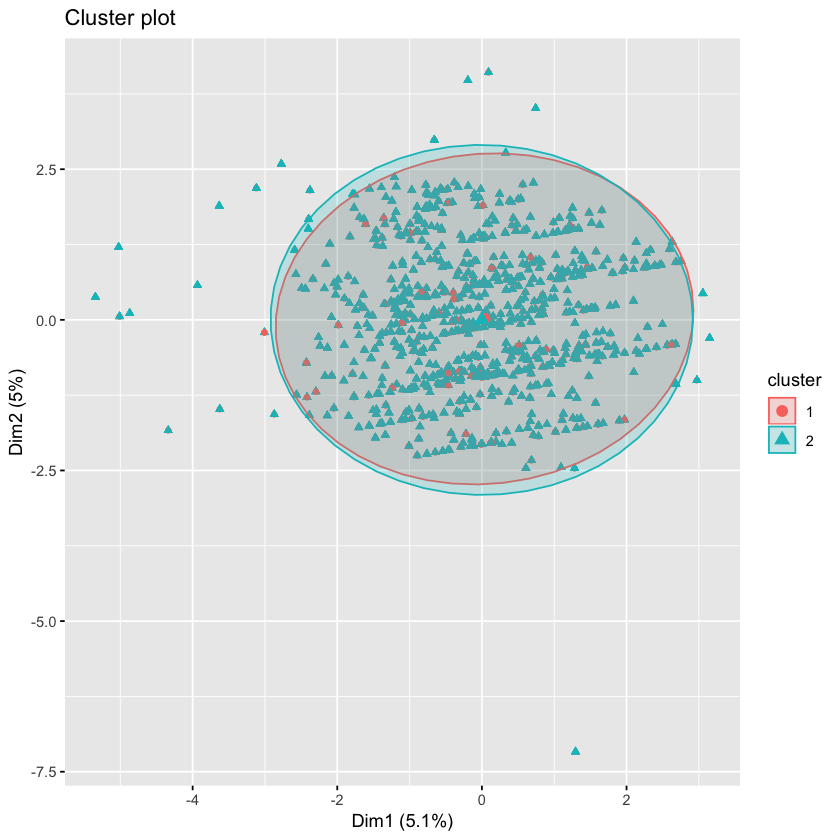

In [88]:
fviz_cluster(kmeans.cluster,
             data = order_sample,
             geom = c("point"), # 點和標籤 c("point","text")
             frame.type = "norm") 

### 採用PCA 的方式，以MemberID 最為基準，計算訂單狀態數量，並以其作為factor

In [37]:
Memstatus$Finish <- as.numeric(Memstatus$Finish)
Memstatus$Cancel <- as.numeric(Memstatus$Cancel)
Memstatus$Overdue <- as.numeric(Memstatus$Overdue)
Memstatus$ReturnGoods <- as.numeric(Memstatus$ReturnGoods)
str(Memstatus)

'data.frame':	843289 obs. of  7 variables:
 $ MemberID   : Factor w/ 563457 levels "1326","1329",..: 123480 123480 123480 123480 123480 123480 123493 123493 123493 123494 ...
 $ Finish     : num  6 6 6 6 6 6 0 0 0 0 ...
 $ Cancel     : num  0 0 0 0 0 0 0 0 0 2 ...
 $ Overdue    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ReturnGoods: num  0 0 0 0 0 0 3 3 3 0 ...
 $ count      : int  6 6 6 6 6 6 3 3 3 2 ...
 $ BL         : num  0 0 0 0 0 0 0 0 0 0 ...


In [38]:
pca <- prcomp(formula = ~ Finish+Overdue+Cancel+ReturnGoods, 
              data = Memstatus,
              scale = TRUE)

### 根據凱莎原則，選取特徵值大於1的主成份，因此選擇前兩個主成份是比較好的選擇。

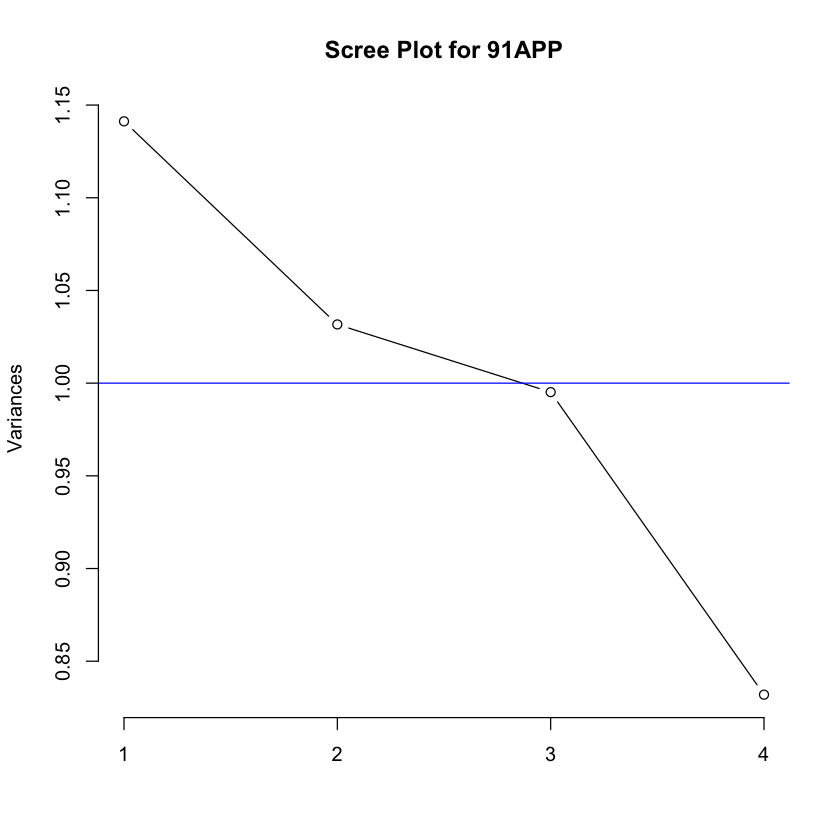

In [39]:
plot(pca,         # 放pca
     type="line", # 用直線連結每個點
     main="Scree Plot for 91APP") # 主標題
abline(h=1, col="blue")

In [40]:
top2_pca <- pca$x[, 1:2]
top2.pca.eigenvector <- pca$rotation[, 1:2]
first.pca <- top2.pca.eigenvector[, 1]
second.pca <- top2.pca.eigenvector[, 2]

### Finish及Cancel與PC1呈現相關性，看起來PC1和「無逆物流」有關。

Cancel      Finish     Overdue ReturnGoods 
 -0.7242930  -0.6445744  -0.1746299  -0.1715455

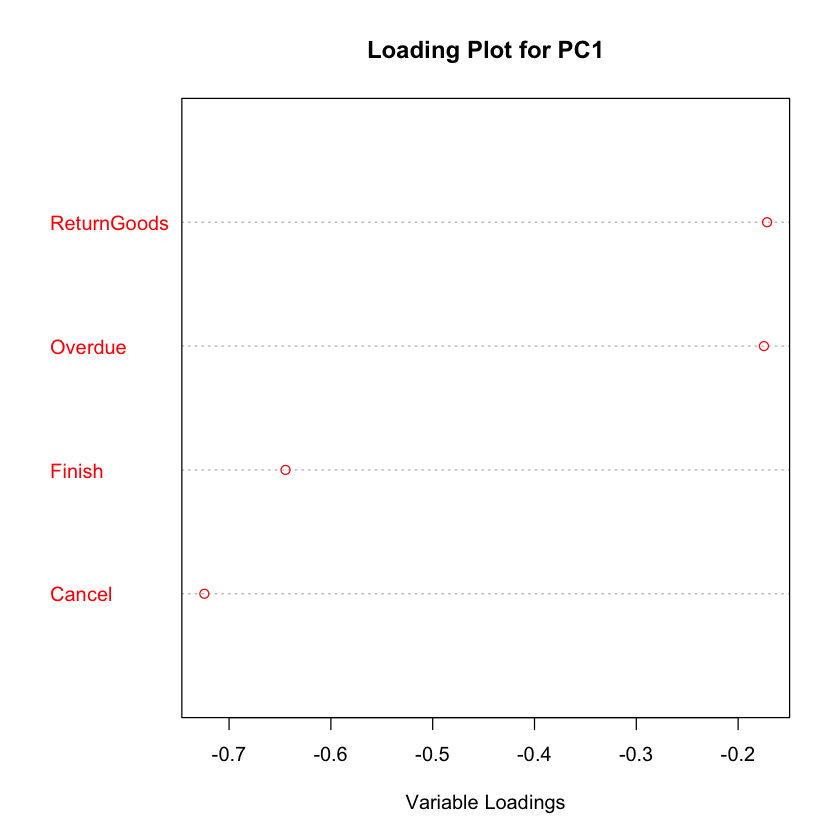

In [41]:
first.pca[order(first.pca, decreasing=FALSE)]  
dotchart(first.pca[order(first.pca, decreasing=FALSE)] ,   # 排序後的係數
         main="Loading Plot for PC1",                      # 主標題
         xlab="Variable Loadings",                         # x軸的標題
         col="red")                                        # 顏色

### Overdue與PC2呈現相關性，看起來PC2和「不取貨」有關。

Overdue      Cancel ReturnGoods      Finish 
 -0.8779764  -0.1703993   0.2683602   0.3579167

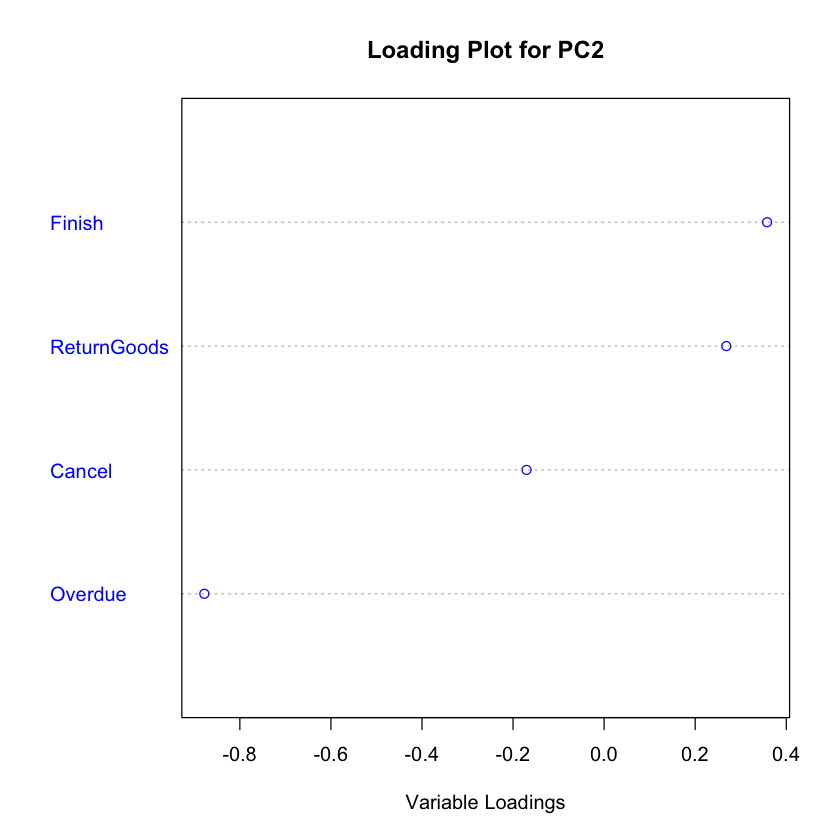

In [42]:
second.pca[order(second.pca, decreasing=FALSE)]  
dotchart(second.pca[order(second.pca, decreasing=FALSE)] ,  # 排序後的係數
         main="Loading Plot for PC2",                       # 主標題
         xlab="Variable Loadings",                          # x軸的標題
         col="blue")                                        # 顏色

In [43]:
scaled_df <- apply(Memstatus[,2:5], 2, scale)
PC1 <- as.matrix(scaled_df) %*% top2.pca.eigenvector[,1]
PC2 <- as.matrix(scaled_df) %*% top2.pca.eigenvector[,2]
PC <- data.frame(Status = Memstatus$MemberID, PC1, PC2)

### 因此要特別注意位於負向極端值的客戶，以免增加回收成本。

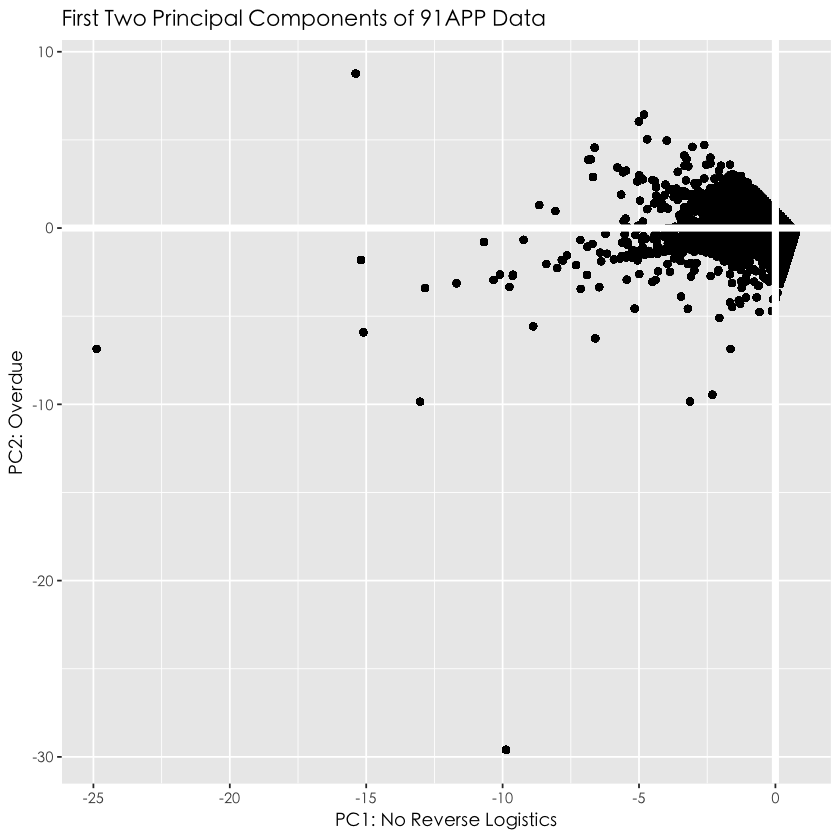

In [46]:
options(warn=-1)
par(family="STHeitiTC-Light")
ggplot(PC, aes(x=PC1, y=PC2)) + 
  geom_point() +
  modelr::geom_ref_line(h = 0) +
  modelr::geom_ref_line(v = 0) +
  #geom_text(aes(label = Status), size = 3) +
  xlab("PC1: No Reverse Logistics") + 
  ylab("PC2: Overdue") + 
  ggtitle("First Two Principal Components of 91APP Data")+
  theme(text=element_text(family="STHeitiTC-Light"))
options(warn=1) 

# Reference
>1. PCA: https://www.jamleecute.com/principal-components-analysis-pca-%E4%B8%BB%E6%88%90%E4%BB%BD%E5%88%86%E6%9E%90/
>2. PCA: https://rpubs.com/skydome20/R-Note7-PCA
>3. Apriori: http://www.rpubs.com/skydome20/R-Note6-Apriori-DecisionTree
>4. k-Means Cluster: http://rpubs.com/skydome20/R-Note9-Clustering